# Adversarial Attacks
* Implement a simple adversarial attack on MNIST images. 

In [83]:
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Own utils Import
from adv_models import Net, GradientAttack
from adv_utils import train_eval, test_eval, test_eval_adv, training_loop, initialize_model

## Pytorch Imports
import torch
import torchvision
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms

In [84]:
## Use gpu
gpu_boole = torch.cuda.is_available()
print(gpu_boole)

# load model for MNIST attack
net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
    net = net.cuda()

True


**Data pipeline:**

In [85]:
#Downloading and unzipping MNIST data files:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10     
        else:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')


xtrain = torch.Tensor(xtrain)
xtrain /= xtrain.max()
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest)
xtest /= xtest.max()
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0   189M      0 --:--:-- --:--:-- --:--:--  189M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  2014k      0 --:--:-- --:--:-- --:--:-- 2014k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  62.8M      0 --:--:-- --:--:-- --:--:-- 62.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0   316k      0 --:--:-- --:--:-- --:--:--  316k


<ipython-input-85-d484e9715f52>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10
<ipython-input-85-d484e9715f52>:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


In [86]:
# parameters
epochs = 20
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [87]:
## Initialize The Attack
adv_attack = GradientAttack(loss_fn, 0.1)

In [88]:
# color channel here is 1
log_dict_mnist = training_loop(epochs, train_loader, test_loader, net, loss_fn, optimizer, adv_attack, 1)

 =======> Starting Training

Epoch 1 :
Elapsed time for epoch: 1.268282175064087 s
ETA of completion: 0.40162268877029417 minutes
Train accuracy: 62.748333 %
Train loss: 0.017413
Test accuracy: 63.239998 %
Test loss: 0.017583
Test accuracy adversarial: 17.010000 %
Test loss adversarial: 0.018172

Epoch 2 :
Elapsed time for epoch: 1.1377274990081787 s
ETA of completion: 0.3413182497024536 minutes
Train accuracy: 69.786667 %
Train loss: 0.010706
Test accuracy: 70.720001 %
Test loss: 0.010676
Test accuracy adversarial: 37.410000 %
Test loss adversarial: 0.014957

Epoch 3 :
Elapsed time for epoch: 1.1260182857513428 s
ETA of completion: 0.31903851429621377 minutes
Train accuracy: 82.271667 %
Train loss: 0.004888
Test accuracy: 82.549995 %
Test loss: 0.004801
Test accuracy adversarial: 33.980000 %
Test loss adversarial: 0.013712

Epoch 4 :
Elapsed time for epoch: 1.0581426620483398 s
ETA of completion: 0.282171376546224 minutes
Train accuracy: 86.586670 %
Train loss: 0.003641
Test accuracy:

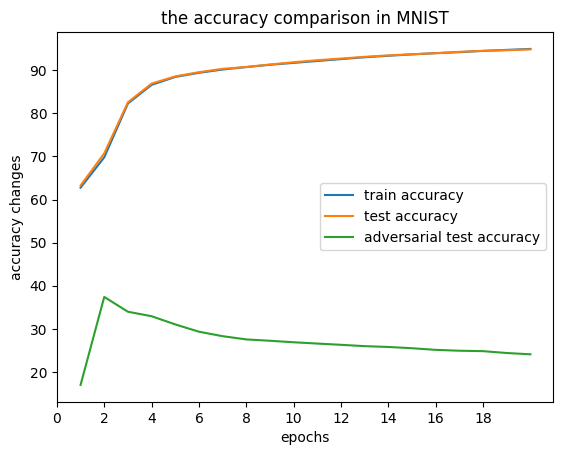

In [89]:
# visualize the acc plot and loss plot
m_train_acc = [i.item() for i in log_dict_mnist['train_acc']]
m_test_acc = [i.item() for i in log_dict_mnist['test_acc']]
m_test_adv_acc = [i.item() for i in log_dict_mnist['test_acc_adv']]

# Create x-axis values (epochs)
epochs = range(1, len(m_train_acc) + 1)

plt.plot(epochs, m_train_acc, label = 'train accuracy')
plt.plot(epochs, m_test_acc, label = 'test accuracy')
plt.plot(epochs, m_test_adv_acc, label = 'adversarial test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy changes')
plt.title('the accuracy comparison in MNIST')
# Set x-axis ticks as integers
plt.xticks(range(0, len(m_train_acc), 2))
plt.legend()
plt.show()

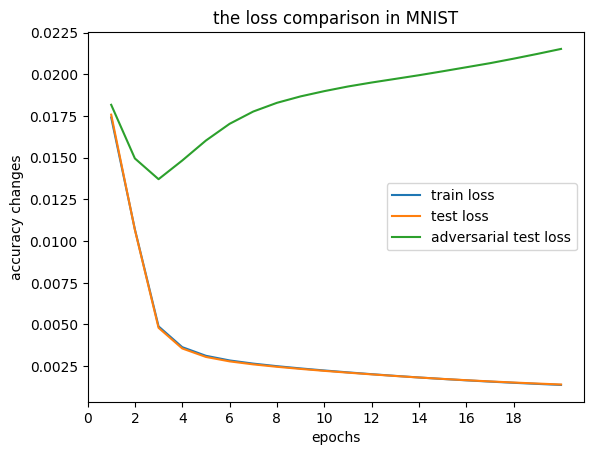

In [90]:
# Create x-axis values (epochs)
epochs = range(1, len(log_dict_mnist['train_loss']) + 1)

plt.plot(epochs, log_dict_mnist['train_loss'], label = 'train loss')
plt.plot(epochs, log_dict_mnist['test_loss'], label = 'test loss')
plt.plot(epochs, log_dict_mnist['test_loss_adv'], label = 'adversarial test loss')
plt.xlabel('epochs')
plt.ylabel('accuracy changes')
plt.title('the loss comparison in MNIST')
# Set x-axis ticks as integers
plt.xticks(range(0, len(log_dict_mnist['train_loss']), 2))
plt.legend()
plt.show()

# Visualize Some Examples

* Visualize a original Image and its corresponding adversarial example.

* Print the prediction of the model for both of the images.

* The adversarial sample should look similar to the original image and be easily and correctly classified by a human.

In [72]:
def plot_adv(train_loader, index=0, color_channel = 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i, (x,y) in enumerate(train_loader):
        x = x.cuda()
        y = y.cuda()
        if color_channel == 1:
            # plot
            axs[0].imshow(x[index].cpu().reshape(28, 28), cmap='gray')
            axs[0].set_title('Original Image')
            label = net(x[index].view(-1,784)).argmax(dim=1)
            axs[0].text(0, -5, 'Predicted label: {}'.format(label.item()), color='red')
            # predict
            in_x = Variable(x[[index]].view(-1, 28*28), requires_grad=True)
            adv_x = adv_attack.forward(in_x, label, net)
            axs[1].imshow(adv_x[0].detach().cpu().reshape(28, 28), cmap='gray')
            axs[1].set_title('Adversarial Image')
            axs[1].text(0, -5, 'Predicted label: {}'.format(net(adv_x[0].view(-1, 784)).argmax(dim=1)[0].item()), color='red')

        elif color_channel == 3:
            # plot
            axs[0].imshow(x[index].cpu().permute(1, 2, 0))
            axs[0].set_title('Original Image')
            label = net(x[index].unsqueeze(0)).argmax(dim=1)  # Add an extra dimension
            axs[0].text(0, -5, 'Predicted label: {}'.format(label.item()), color='red') 
            # predict
            in_x = Variable(x[[index]], requires_grad=True)
            adv_x = adv_attack.forward(in_x, label, net)
            axs[1].imshow(adv_x[0].detach().cpu().permute(1, 2, 0))
            axs[1].set_title('Adversarial Image')
            axs[1].text(0, -5, 'Predicted label: {}'.format(net(adv_x[0].unsqueeze(0)).argmax(dim=1)[0].item()), color='red')           
        break

    plt.show()

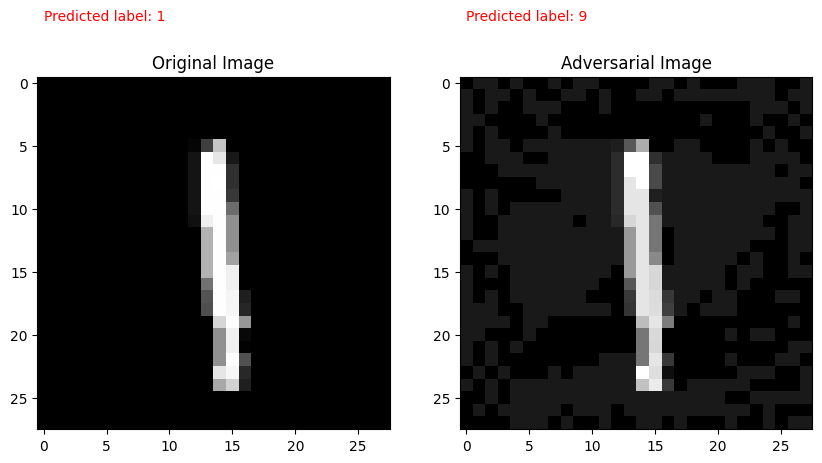

In [91]:
plot_adv(train_loader, 8, 1)

# Adversarial Attacks CIFAR Attack

In [12]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12897726.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
## Get Model
net = initialize_model(True, False, 10)
net = net.cuda()

# adam
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()

In [17]:
## Initialize The Attack
adv_attack_cifar = GradientAttack(loss_metric, 0.1)

In [18]:
# color channel here is 3
log_dict_cifar = training_loop(20, trainloader, testloader, net, loss_metric, optimizer, adv_attack_cifar, 3)

 =======> Starting Training

Epoch 1 :
Elapsed time for epoch: 57.11253881454468 s
ETA of completion: 18.08563729127248 minutes
Train accuracy: 44.798000 %
Train loss: 0.011658
Test accuracy: 44.379997 %
Test loss: 0.011878
Test accuracy adversarial: 9.920000 %
Test loss adversarial: 0.023302

Epoch 2 :
Elapsed time for epoch: 53.741429567337036 s
ETA of completion: 16.122428870201112 minutes
Train accuracy: 56.174000 %
Train loss: 0.009568
Test accuracy: 54.619999 %
Test loss: 0.009977
Test accuracy adversarial: 10.110000 %
Test loss adversarial: 0.026110

Epoch 3 :
Elapsed time for epoch: 53.44090795516968 s
ETA of completion: 15.141590587298076 minutes
Train accuracy: 64.970001 %
Train loss: 0.007676
Test accuracy: 62.139999 %
Test loss: 0.008353
Test accuracy adversarial: 10.820000 %
Test loss adversarial: 0.028237

Epoch 4 :
Elapsed time for epoch: 53.392855644226074 s
ETA of completion: 14.238094838460286 minutes
Train accuracy: 69.155998 %
Train loss: 0.006816
Test accuracy: 65.

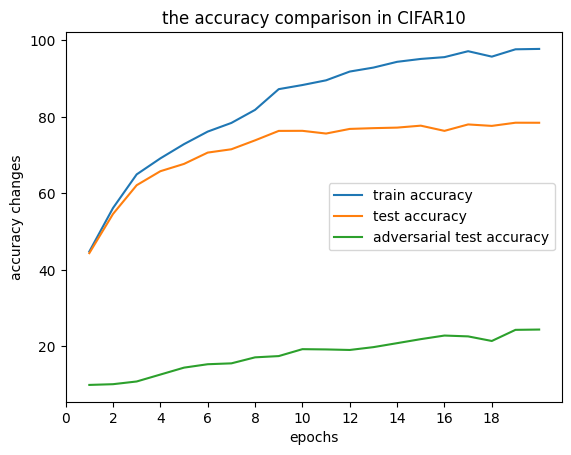

In [26]:
# visualize the acc plot and loss plot
c_train_acc = [i.item() for i in log_dict_cifar['train_acc']]
c_test_acc = [i.item() for i in log_dict_cifar['test_acc']]
c_test_adv_acc = [i.item() for i in log_dict_cifar['test_acc_adv']]

# Create x-axis values (epochs)
epochs = range(1, len(c_train_acc) + 1)

plt.plot(epochs, c_train_acc, label = 'train accuracy')
plt.plot(epochs, c_test_acc, label = 'test accuracy')
plt.plot(epochs, c_test_adv_acc, label = 'adversarial test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy changes')
plt.title('the accuracy comparison in CIFAR10')
# Set x-axis ticks as integers
plt.xticks(range(0, len(c_train_acc), 2))
plt.legend()
plt.show()

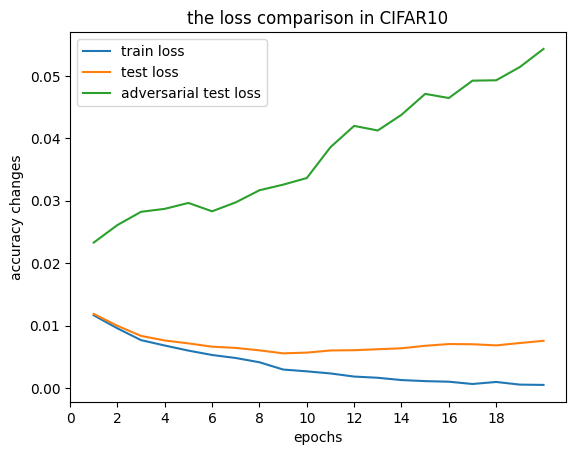

In [28]:
# Create x-axis values (epochs)
epochs = range(1, len(log_dict_cifar['train_loss']) + 1)

plt.plot(epochs, log_dict_cifar['train_loss'], label = 'train loss')
plt.plot(epochs, log_dict_cifar['test_loss'], label = 'test loss')
plt.plot(epochs, log_dict_cifar['test_loss_adv'], label = 'adversarial test loss')
plt.xlabel('epochs')
plt.ylabel('accuracy changes')
plt.title('the loss comparison in CIFAR10')
# Set x-axis ticks as integers
plt.xticks(range(0, len(log_dict_cifar['train_loss']), 2))
plt.legend()
plt.show()

Files already downloaded and verified


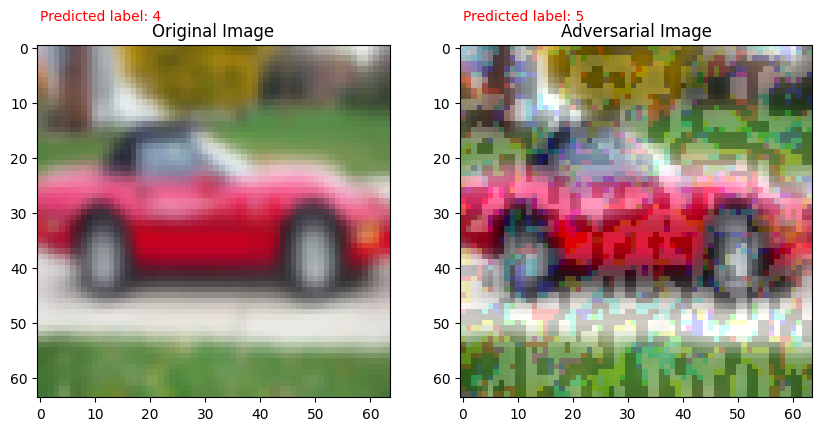

In [78]:
## Transformations
transform_visual = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset_visual = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_visual)
trainloader_visual = torch.utils.data.DataLoader(trainset_visual, batch_size=batch_size,
                                          shuffle=True)

plot_adv(trainloader_visual, 8, 3)